## Module 01: Generate embeddings using text-embedding-ada-002 model.

嵌入对于处理自然语言和代码非常有用，因为其他机器学习模型和算法（如聚类或搜索）可以轻松地使用和比较它们。

![Embedding](images/embedding-vectors.svg)

### 亚马逊美食评论数据集(amazon-fine-food-reviews)

Source:[美食评论数据集](https://www.kaggle.com/snap/amazon-fine-food-reviews)

![dataset](images/amazon-fine-food-reviews.png)


该数据集包含截至2012年10月用户在亚马逊上留下的共计568,454条美食评论。为了说明目的，我们将使用该数据集的一个子集，其中包括最近1,000条评论。这些评论都是用英语撰写的，并且倾向于积极或消极。每个评论都有一个产品ID、用户ID、评分、标题（摘要）和正文。

我们将把评论摘要和正文合并成一个单一的组合文本。模型将对这个组合文本进行编码，并输出一个单一的向量嵌入。

In [2]:
import os
from dotenv import load_dotenv
import openai

_ = load_dotenv('../tokens.env')
openai.api_key = os.environ['OPENAI_API_KEY']

In [4]:
import pandas as pd

# Tiktoken是OpenAI开发的一个库，用于从模型生成的文本中计算token数量
import tiktoken

# 从 openai.embeddings_utils导入get_embedding
# 这个函数可以获取GPT-3模型生成的嵌入向量
# 嵌入向量是模型内部用于表示输入数据的一种形式
from openai.embeddings_utils import get_embedding

#### Step 01: Load data

In [5]:
input_datapath = "data/fine_food_reviews_1k.csv"
df = pd.read_csv(input_datapath, index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()

# Summary and Text to form combined
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
df.head(2)

,Time,ProductId,UserId,Score,Summary,Text,combined
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...


In [22]:
# get all possible values from the column "Score"
df.Score.unique()

array([5, 1, 4, 3, 2])

In [5]:
df["combined"].sample(3)

660    Title: Rodeo Drive is Crazy Good Coffee!; Cont...
974    Title: Love It!; Content: If you've never had ...
978    Title: Great Treat; Content: My cats love thes...
Name: combined, dtype: object

In [6]:
df.shape

(1000, 7)

#### Step 02: Setup embedding key parameters

In [7]:
# recommended 2nd generation model
embedding_model = "text-embedding-ada-002"

# ada-002's TOKENIZER used by tiktoken
embedding_encoding = "cl100k_base"
tokenizer = tiktoken.get_encoding(embedding_encoding)

# ada-002 supports max.token 8191, vector dims 1536
# filter text larger than 8,000 tokens
max_tokens = 8000  

#### Step 03: Reduce samples to "top_n" and delete records exceeds "max_tokens"

In [8]:
top_n = 99

# 首先将前2k个条目进行初始筛选，假设不到一半会被过滤掉。
df = df.sort_values("Time").head(top_n)

# 计算每条数据的token数量
df["n_tokens"] = df.combined.apply(lambda x: len(tokenizer.encode(x)))

# 删除token数量不符合条件的数据
df = df[df.n_tokens <= max_tokens]
len(df)

99

#### Step 04：Generate embeddings and save

In [9]:
from tqdm import tqdm 

# to ensure ["combined"] astype String
df.combined = df.combined.astype(str)

# init an empty holderlist
embeddings = []

# get embeddings from openai.get_embedding
# df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))
for combined in tqdm(df.combined):
    embedding = get_embedding(combined, engine=embedding_model)  
    embeddings.append(embedding)

df["embedding"] = embeddings

# output to file
output_datapath = "data/fine_food_reviews_with_embeddings_100.csv"
df.to_csv(output_datapath)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:51<00:00,  1.91it/s]


## Module 02: Read embeddings which are generated above

In [5]:
embedding_datapath = "data/fine_food_reviews_with_embeddings_1k.csv"
df_emb = pd.read_csv(embedding_datapath, index_col=0)

In [7]:
df_emb.sample(2)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding
21,B006N3HZ6K,A3NIBMLKUK73JC,5,Great flavor no bite,This coffee is a favorite of mine and many oth...,Title: Great flavor no bite; Content: This cof...,33,"[-0.01839999482035637, -0.015677006915211678, ..."
744,B005J0N5ZI,AK42RQFIGJAEJ,5,OMG!!!,I just want to start off by saying that I am a...,Title: OMG!!!; Content: I just want to start o...,198,"[-0.006378937046974897, -0.02776752971112728, ..."


In [37]:
df_emb["embedding"].sample(5)

188    [-0.004120416473597288, 0.014028709381818771, ...
662    [-0.0031374385580420494, -0.02342180348932743,...
772    [-0.0053741103038191795, -0.004452646244317293...
435    [-0.021623501554131508, -0.003407036419957876,...
263    [-0.002289338270202279, -0.01313735730946064, ...
Name: embedding, dtype: object

In [12]:
# as str
len(df_emb["embedding"][0])

34403

In [13]:
type(df_emb["embedding"][0])

str

### *Parse representation from str to list

In [11]:
import ast
df_emb["embedding_vec"] = df_emb["embedding"].apply(ast.literal_eval)

In [15]:
len(df_emb["embedding_vec"][0])

1536

In [16]:
type(df_emb["embedding_vec"][0])

list

## 3. 使用TSNE可视化1536维的评论数据

In [8]:
# numpy是Python的一个开源数值计算扩展，这种工具可用来存储和处理大型矩阵；
# numpy比Python自身的嵌套列表(nested list structure)结构要高效的多。
import numpy as np

# matplotlib导入pyplot子库，并将其别名设置为plt；
import matplotlib.pyplot as plt

# sklearn.manifold导入TSNE类
# t-SNE (t-Distributed Stochastic Neighbor Embedding) 是一种数据可视化的降维方法，尤其擅长处理高维数据的可视化；
# 它可以将高维度的数据映射到2D或3D的空间中，以便我们可以直观地观察和理解数据的结构。
from sklearn.manifold import TSNE

In [12]:
# 首先，确保你的嵌入向量都是等长的
assert df_emb['embedding_vec'].apply(len).nunique() == 1

In [13]:
# 将嵌入向量列表转换为二维numpy数组
matrix = np.vstack(df_emb['embedding_vec'].values)

In [45]:
# confirm sample_n and dim_m as (99.1536)
matrix.shape

(1000, 1536)

In [14]:
# 创建一个t-SNE模型，t-SNE是一种非线性降维方法，常用于高维数据可视化；
# n_components：表示降维后的维度（在这里是2D）
# perplexity：可以被理解为近邻的数量
# random_state：是随机数生成器的种子
# init：设置初始化方式
# learning_rate：学习率
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)

In [15]:
# 使用t-SNE对数据进行降维，得到每个数据点在新的2D空间中的坐标
vis_dims = tsne.fit_transform(matrix)

In [20]:
vis_dims.shape

(1000, 2)

In [17]:
# 定义了五种不同的颜色，用于在可视化中表示不同的等级(1,2,3,4,5)
colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]

In [18]:
# 从降维后的坐标中分别获取所有数据点的横坐标和纵坐标
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

# 根据数据点的评分（减1是因为评分是从1开始的，而颜色索引是从0开始的）获取对应的颜色索引
color_indices = df_emb.Score.values - 1

# 确保你的数据点和颜色索引的数量匹配
assert len(vis_dims) == len(df_emb.Score.values)

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

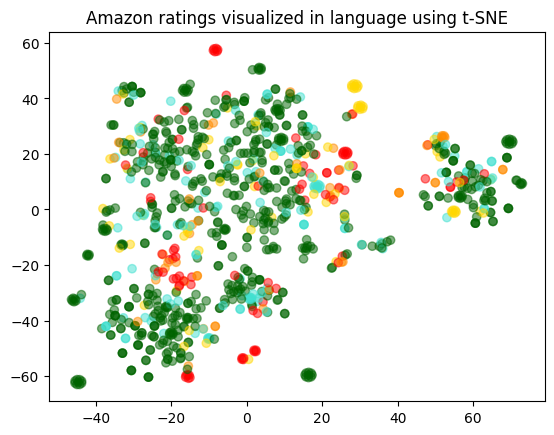

In [21]:
# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)

# 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定，alpha是点的透明度
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.5)

# 为图形添加标题
plt.title("Amazon ratings visualized in language using t-SNE")

**t-SNE降维后，产生了大约3个大类，其中1个大类的评论大多是负面的。**

## 4. 使用K-Means聚类，然后再使用t-SNE可视化

In [23]:
import numpy as np

# scikit-learn导入KMeans类，实现K-Means聚类算法
from sklearn.cluster import KMeans

# 定义要生成的聚类数。
n_clusters = 5

# 创建一个 KMeans 对象，用于进行 K-Means 聚类。
# n_clusters 参数指定了要创建的聚类的数量；
# init 参数指定了初始化方法（在这种情况下是 'k-means++'）；
# random_state 参数为随机数生成器设定了种子值，用于生成初始聚类中心。
kmeans = KMeans(
    n_clusters = n_clusters, 
    init='k-means++', 
    random_state=42
)

# 使用 matrix（我们之前创建的矩阵）来训练 KMeans 模型。这将执行 K-Means 聚类算法。
kmeans.fit(matrix)

# kmeans.labels_ 属性包含每个输入数据点所属的聚类的索引。
# 这里，我们创建一个新的 'Cluster' 列，在这个列中，每个数据点都被赋予其所属的聚类的标签。
df_emb['Cluster'] = kmeans.labels_

/Users/youweizheng/.pyenv/versions/lach/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [52]:
df_emb['Cluster']

0      3
297    2
296    3
295    0
294    3
      ..
623    2
624    0
625    1
619    2
999    2
Name: Cluster, Length: 1000, dtype: int32

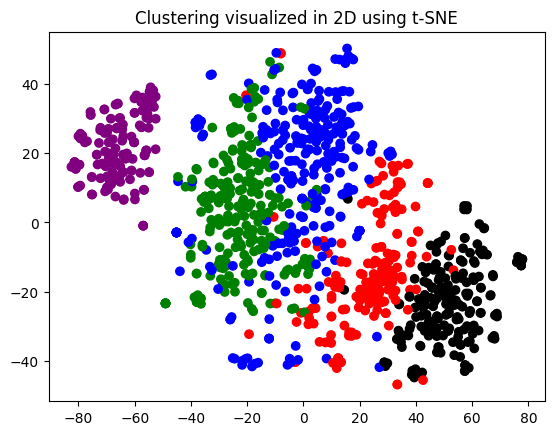

In [24]:
# 首先为每个聚类定义一个颜色。
colors = ["red", "green", "blue", "purple", "black"]

# 然后，你可以使用 t-SNE 来降维数据。这里，我们只考虑 'embedding_vec' 列。
tsne_model = TSNE(n_components=2, random_state=42)
vis_data = tsne_model.fit_transform(matrix)

# 现在，你可以从降维后的数据中获取 x 和 y 坐标。
x = vis_data[:, 0]
y = vis_data[:, 1]

# 'Cluster' 列中的值将被用作颜色索引。
color_indices = df_emb['Cluster'].values

# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)

# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定
plt.scatter(x, y, c=color_indices, cmap=colormap)

# 为图形添加标题
plt.title("Clustering visualized in 2D using t-SNE")

# 显示图形
plt.show()

**K-MEANS 聚类可视化效果，4类：一个专注于狗粮，一个专注于负面评论，两个专注于正面评论。**

## 5. 使用Embedding进行文本搜索

![cosine](images/cosine.png)

In [13]:
# cosine_similarity函数：计算两个向量之间的余弦相似度
from openai.embeddings_utils import cosine_similarity

In [14]:
product_description = "delicious beans"

product_embedding = get_embedding(
    product_description,
    engine="text-embedding-ada-002"
)

df_emb["similarity"] = df_emb.embedding_vec.apply(lambda x: cosine_similarity(x, product_embedding))

In [15]:
df_emb.sample(5)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,embedding_vec,similarity
450,B0042WXFJU,A3KUC5K5VSJNU9,5,It's FANTASTIC! Mixes with Many kinds of Soups...,"I just love it, and I am Not a major Indian co...",Title: It's FANTASTIC! Mixes with Many kinds o...,309,"[0.006242592353373766, -0.01492215134203434, -...","[0.006242592353373766, -0.01492215134203434, -...",0.815983
168,B000FBM46W,A2XVOWD40JCFSZ,4,yummy cookies!,We've ordered for them every month and only on...,Title: yummy cookies!; Content: We've ordered ...,33,"[-0.00998296681791544, -0.0160784013569355, 0....","[-0.00998296681791544, -0.0160784013569355, 0....",0.794454
30,B001EQ5MT8,A1LZ8VQVNPI30N,5,Better than you-know-who's coffee...,"So my wife is a latte freak, and nursing, so d...",Title: Better than you-know-who's coffee...; C...,165,"[-0.005762138403952122, 0.007266039494425058, ...","[-0.005762138403952122, 0.007266039494425058, ...",0.760273
918,B001PQOB4O,ARF9K2APJHAH3,5,Best cornbread mix ever!!!!,Great corn bread mix.Perfect for thanksgiving....,Title: Best cornbread mix ever!!!!; Content: G...,44,"[-0.006555605214089155, -0.013562406413257122,...","[-0.006555605214089155, -0.013562406413257122,...",0.772679
267,B002ACU9XY,A32C7CN1ZWSDEK,5,Favorite Coffee Pods!,I had been buying Senseo coffee pods to use in...,Title: Favorite Coffee Pods!; Content: I had b...,154,"[-0.006169728934764862, -0.015072627924382687,...","[-0.006169728934764862, -0.015072627924382687,...",0.800634


In [57]:
# 定义一个名为search_reviews的函数
# 输入参数：Pandas DataFrame，产品描述，数量，以及是否打印标志
def search_reviews(df, product_description, n=3, pprint=True):
    product_embedding = get_embedding(
        product_description,
        engine="text-embedding-ada-002"
    )
    df["similarity"] = df.embedding_vec.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        # 按相似度排序
        df.sort_values("similarity", ascending=False)
        # 取前三条记录
        .head(n)
        # 处理输出文字
        .combined.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
    
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results

In [59]:
# 使用“delicious beans”作为产品描述和3作为数量
# 调用search_reviews函数来查找与给定产品描述最相似的前3条评论
# 其结果被存储在res变量中
res = search_reviews(df_emb, 'delicious beans', n=3)

Good Buy:  I liked the beans. They were vacuum sealed, plump and moist. Would recommend them for any use. I personally split and stuck them in some vodka to make vanilla extract. Yum!

Jamaican Blue beans:  Excellent coffee bean for roasting. Our family just purchased another 5 pounds for more roasting. Plenty of flavor and mild on acidity when roasted to a dark brown bean and befor

Delicious!:  I enjoy this white beans seasoning, it gives a rich flavor to the beans I just love it, my mother in law didn't know about this Zatarain's brand and now she is traying different seasoning



In [75]:
df_embeded['Cluster']

0      3
297    2
296    3
295    0
294    3
      ..
623    2
624    0
625    1
619    2
999    2
Name: Cluster, Length: 1000, dtype: int32

In [76]:
# 选一条类别3的评论
df_embeded['combined'][0]

'Title: where does one  start...and stop... with a treat like this; Content: Wanted to save some to bring to my Chicago family but my North Carolina family ate all 4 boxes before I could pack. These are excellent...could serve to anyone'

In [77]:
res = search_reviews(df_embeded, df_embeded['combined'][0], n=3)

where does one  start...and stop... with a treat like this:  Wanted to save some to bring to my Chicago family but my North Carolina family ate all 4 boxes before I could pack. These are excellent...c

Perfect Gift:  I got these to give out in a goodie bag for the holidays, with a couple extras of course.  They arrived quickly, the price was right, and they were delicious!  I can't wait to give them

Delicious!:  Love these packs. I have made pretzel dogs, bites and sticks. I  have even used the pretzel mix to make calzones and pizza. Both came out great.



In [78]:
res = search_reviews(df_embeded, 'dog food', n=3)

Healthy Dog Food:  This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.

Doggy snacks:  My dog loves these snacks. However they are made in China and as far as I am concerned, suspect!!!! I found an abundance of American made ,human grade chicken dog snacks. Just Google fo

Dogs Love Them!:  My Maltese and Cavalier King Charles love these treats!  I feel good about feeding them a healthier treat.<br />Not made in China!



In [79]:
res = search_reviews(df_embeded, 'awful', n=5)

God Awful:  As a dabbler who enjoys spanning the entire spectrum of taste, I am more than willing to try anything once.  Both as a food aficionado and a lover of bacon, I just had to pick this up.  On

Disappointed:  The metal cover has severely disformed. And most of the cookies inside have been crushed into small pieces. Shopping experience is awful. I'll never buy it online again.

Just Bad:  Watery and unpleasant.  Like Yoohoo mixed with dirty dish water.  I find it quite odd that Keurig would release a product like this.  I'm sure they can come up with a decent hot chocolate a

Arrived in pieces:  Not pleased at all. When I opened the box, most of the rings were broken in pieces. A total waste of money.

Awesome:  They arrived before the expected time and were of fantastic quality. Would recommend to any one looking for a awesome treat

